### Bars and Stripes

Import libraries

In [492]:
import numpy as np
import pennylane as qml
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from pennylane import numpy as pnp

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

import optax

from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from pennylane_qiskit import AerDevice
from pennylane_ionq import ops
from qiskit_aer import AerSimulator


Generate Bars and Stripes dataset

In [493]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)
    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))


#Size of Bars and Stripes
n = 3
size = n**2
n_qubits = size
data = get_bars_and_stripes(n)

bitstrings = []
nums = []
for d in data:
    bitstrings += ["".join(str(int(i)) for i in d)]
    nums += [int(bitstrings[-1], 2)]
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

#Seeding
params = np.random.random(size=n_qubits*6*3+1)
paramsoriginal = params

#Noise cooficient
p=0

Define the used pennylane device

In [494]:

#dev = AerDevice(wires=n_qubits, backend='aer_simulator')
#dev = qml.device("ionq.simulator", wires=n_qubits)
#dev = qml.device("default.qubit", wires=n_qubits)
dev = qml.device("default.mixed", wires=n_qubits)
#dev = qml.device("qiskit.aer", wires=n_qubits)


# Circuits

In [495]:
def qdi_layer(parameters):
    param_index = 0
    m = 1
    d = 4
    
    for i in range(m):
        # Apply parameterized gates
        for qubit in range(n_qubits):
            qml.RX(parameters[param_index], qubit)
            param_index += 1
        # Apply CNOT gates for entanglement
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

    for i in range(d):
        for qubit in range(n_qubits):
            qml.RZ(parameters[param_index], qubit)
            param_index += 1

        for j in range(m):
            # Apply parameterized gates
            for qubit in range(n_qubits):
                qml.RX(parameters[param_index], qubit)
                param_index += 1
            # Apply CNOT gates for entanglement
            for qubit in range(n_qubits - 1):
                qml.CNOT(wires=[qubit, qubit + 1])
            qml.CNOT(wires=[n_qubits - 1, 0])
    for qubit in range(n_qubits):
        qml.BitFlip(p, wires=qubit)
    
    return qml.probs(wires=range(n_qubits))


In [496]:
def pqn_layer(parameters):
    param_index = 0
    i = 6
    for qubit in range(n_qubits):
            qml.RX(parameters[param_index], qubit)
            param_index += 1
    
    for k in range(i):
        # Apply parameterized gates
        for qubit in range(n_qubits):
            qml.RZ(parameters[param_index], qubit)
            param_index += 1
            qml.RY(parameters[param_index], qubit)
            param_index += 1
            qml.RZ(parameters[param_index], qubit)
            param_index += 1
        # Apply CNOT gates for entanglement
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
    for qubit in range(n_qubits):
        qml.BitFlip(p, wires=qubit)
    return qml.probs(wires=range(n_qubits))


In [497]:
def efq_layer(parameters):
    param_index = 1
    x = parameters[0]
    n = 6
    for k in range(n):
        #W part
        for qubit in range(n_qubits):
            qml.RY(parameters[param_index], qubit)
            param_index += 1
            qml.RZ(parameters[param_index], qubit)
            param_index += 1
            qml.RX(parameters[param_index], qubit)
            param_index += 1

            qml.RZ((2**k + 1)*x, qubit)
            
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
    for qubit in range(n_qubits):
        qml.BitFlip(p, wires=qubit)
    return qml.probs(wires=range(n_qubits))



In [498]:
def strong_layer(parameters):
    #circuit = strong_layer(n_qubits, params, 6)
    #measurements = qml.from_qiskit(circuit)()
    param_index=0
    for i in range(6):
        for qubit in range(n_qubits):
            qml.RX(parameters[param_index], wires=qubit)
            param_index += 1
            qml.RY(parameters[param_index], wires=qubit)
            param_index += 1
            qml.RZ(parameters[param_index], wires=qubit)
            param_index += 1
        # Apply CNOT gates for entanglement
        for qubit in range(n_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
        #for qubit in range(n_qubits):
        #    qml.BitFlip(0.05, wires=qubit)
    for qubit in range(n_qubits):
        qml.BitFlip(p, wires=qubit)
    return qml.probs(wires=range(n_qubits))


# Strong layer

Choosing the Strong layer

In [499]:
@qml.qnode(dev)
def circuit(parameters):
    return strong_layer(parameters)
jit_circuit = jax.jit(circuit)

Cost function

In [500]:
def costsquare(params):
    output_probs = jit_circuit(params)
    
    target_probs = probs
    cost_value = jnp.sum( jnp.square(target_probs-output_probs))
    return cost_value, target_probs

Optimize the quantum circuit

In [501]:

#params = np.random.random(size=n_qubits*4*3)
params = paramsoriginal


opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(params)


@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(costsquare, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val


history = []
n_iterations = 100

for i in range(n_iterations):
    params, opt_state, loss_val = update_step(params, opt_state)

    if i%10==0:
        print(f"Step: {i} Loss: {loss_val:.4f}")

    history.append(loss_val)
print(params)
optimal_params=params
output_probs = circuit(optimal_params)



#print(optimal_params)
#print(output_probs)

Step: 0 Loss: 0.0708
Step: 10 Loss: 0.0369
Step: 20 Loss: 0.0237
Step: 30 Loss: 0.0172
Step: 40 Loss: 0.0113
Step: 50 Loss: 0.0074
Step: 60 Loss: 0.0052
Step: 70 Loss: 0.0043
Step: 80 Loss: 0.0037
Step: 90 Loss: 0.0034
[-7.74411459e-03  9.60119230e-01  8.48436955e-01  9.90499754e-01
  5.88933600e-01  5.43096008e-01  3.26604615e-01  2.10518002e-02
  1.39807823e+00  8.86826586e-01  1.28748989e+00  9.53377753e-01
  5.92827986e-01 -1.52776943e-01  2.63077241e-01  1.37285515e-01
 -3.61176083e-02  5.13844722e-02  1.42079048e+00  1.90150741e+00
  9.25039005e-01  4.89022946e-01 -2.77904009e-01  1.46708073e-01
 -8.61540582e-04  1.27490767e-03  2.30184202e-01  1.78642113e+00
  1.88037542e+00  9.50150626e-01 -7.85611707e-01 -6.92305464e-01
  3.61398922e-01 -4.34739528e-01 -8.82857332e-01 -1.33188096e-01
  8.39374743e-01  1.47394723e+00 -1.59714732e+00 -8.47232934e-01
  3.71140248e-01  2.53236786e-01 -3.25892324e-01  1.53229434e+00
  1.52941398e-02 -2.12021260e-01  7.95662056e-01 -2.29462713e-01
 

Plot histogram of Strong Layer

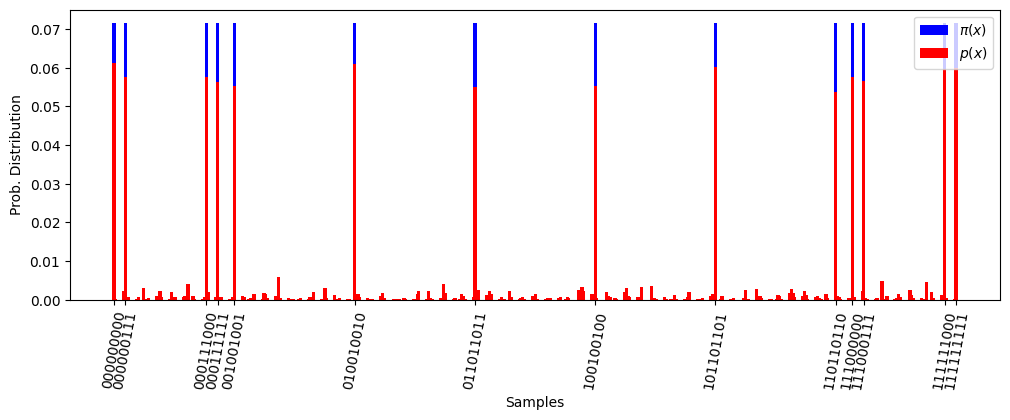

In [502]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of Strong Layer

In [503]:
acr=0
for i in nums:
    acr+=output_probs[i]
print(acr)

0.8061344445378059


# QDI layer

Choosing the QDI layer

In [504]:
@qml.qnode(dev)
def circuit(parameters):
    return qdi_layer(parameters)
jit_circuit = jax.jit(circuit)

Cost function

In [505]:
def costsquare(params):
    output_probs = jit_circuit(params)
    
    target_probs = probs
    cost_value = jnp.sum( jnp.square(target_probs-output_probs))
    return cost_value, target_probs

Optimize the quantum circuit

In [506]:

#params = np.random.random(size=n_qubits*4*3)
params = paramsoriginal


opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(params)


@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(costsquare, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val


history2 = []
n_iterations = 100

for i in range(n_iterations):
    params, opt_state, loss_val = update_step(params, opt_state)

    if i%10==0:
        print(f"Step: {i} Loss: {loss_val:.4f}")

    history2.append(loss_val)
print(params)
optimal_params=params
output_probs = circuit(optimal_params)



#print(optimal_params)
#print(output_probs)

Step: 0 Loss: 0.0706
Step: 10 Loss: 0.0486
Step: 20 Loss: 0.0338
Step: 30 Loss: 0.0261
Step: 40 Loss: 0.0237
Step: 50 Loss: 0.0228
Step: 60 Loss: 0.0221
Step: 70 Loss: 0.0220
Step: 80 Loss: 0.0218
Step: 90 Loss: 0.0217
[-4.90617654e-03  6.56610349e-04 -1.17236897e-01 -1.50823265e-02
 -7.17025617e-02  1.77411480e+00  1.27687980e+00 -1.29121372e+00
 -1.06644484e+00  3.32371316e-01 -3.54283017e-01  2.62597392e-01
  7.64280042e-01 -3.02579292e-02 -3.20123831e-02  1.21653602e+00
  1.44528324e+00 -2.45976467e-01  1.50084330e+00 -2.00473659e-02
  4.22838910e-01  6.91417177e-01 -2.34772145e-02  1.60256691e+00
  1.36499847e+00  4.32963136e-01 -1.27735916e+00  2.93635411e+00
  9.67841159e-01  1.43115964e+00  2.81525869e-01 -9.30780504e-02
  1.70802069e+00 -1.63327859e+00  1.03676718e+00  9.91783514e-01
 -2.75044402e-02  2.23873940e-02 -3.30973281e-01 -1.54947735e-01
  1.59611688e-01 -3.67382770e-01  1.34865048e+00 -1.58792015e+00
  1.10346726e-02 -2.81290696e-01  1.82454889e+00  8.52467618e-01
 

Plot histogram of QDI Layer

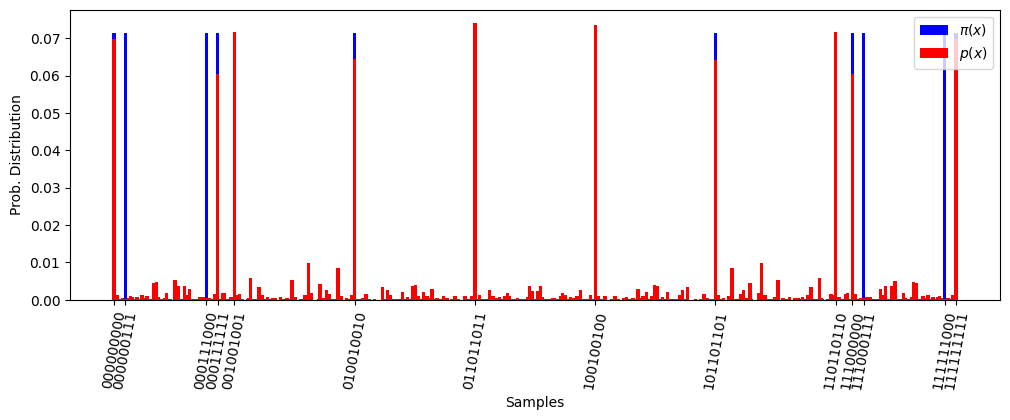

In [507]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of QDI Layer

In [508]:
acr2=0
for i in nums:
    acr2+=output_probs[i]
print(acr2)

0.6810690575415315


# PQN layer

Choosing the PQN layer

In [509]:
@qml.qnode(dev)
def circuit(parameters):
    return pqn_layer(parameters)
jit_circuit = jax.jit(circuit)

Cost function

In [510]:
def costsquare(params):
    output_probs = jit_circuit(params)
    
    target_probs = probs
    cost_value = jnp.sum( jnp.square(target_probs-output_probs))
    return cost_value, target_probs

Optimize the quantum circuit

In [511]:

#params = np.random.random(size=n_qubits*4*3)
params = paramsoriginal


opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(params)


@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(costsquare, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val


history3 = []
n_iterations = 100

for i in range(n_iterations):
    params, opt_state, loss_val = update_step(params, opt_state)

    if i%10==0:
        print(f"Step: {i} Loss: {loss_val:.4f}")

    history3.append(loss_val)
print(params)
optimal_params=params
output_probs = circuit(optimal_params)



#print(optimal_params)
#print(output_probs)

Step: 0 Loss: 0.0693
Step: 10 Loss: 0.0457
Step: 20 Loss: 0.0360
Step: 30 Loss: 0.0306
Step: 40 Loss: 0.0280
Step: 50 Loss: 0.0243
Step: 60 Loss: 0.0164
Step: 70 Loss: 0.0125
Step: 80 Loss: 0.0111
Step: 90 Loss: 0.0070
[-5.37624398e-02 -1.18171386e-02 -1.48246607e-01  2.72589672e-02
  2.58761724e-02 -6.16545765e-02  5.18216258e-01  1.39126403e-02
  1.67404926e+00  1.56273283e+00  3.15344132e-02  4.67767873e-02
  1.02832713e+00 -1.59129779e-02  9.60749243e-01  1.75875495e+00
  1.66020193e-01  1.36926010e+00  1.59464635e+00  9.69752059e-01
  7.15893771e-01 -8.32988084e-01  7.61890427e-02  3.46915553e-01
  3.50944711e-01  1.81008364e-02  7.11069609e-01  9.24186219e-01
  9.05560958e-01  2.40739788e-01  9.57186640e-02 -5.23903238e-02
  1.26811842e+00 -3.51984234e-01  1.33204751e+00  1.90799974e-01
  4.54050804e-01  1.35169673e+00  8.08392073e-01 -1.37202696e-01
  1.23379496e+00  2.39164824e-01  1.95637677e+00  3.19561513e-02
  8.18738519e-01  1.44554364e-02 -1.36629480e-02 -6.25219243e-01
 

Plot histogram of PQN layer

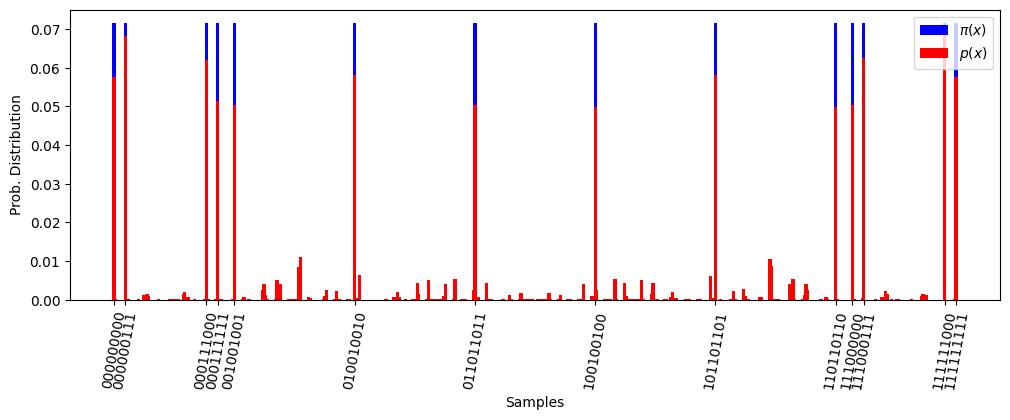

In [512]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of PQN layer

In [513]:
acr3=0
for i in nums:
    acr3+=output_probs[i]
print(acr3)

0.7938991896144697


# EFQ layer

Choosing the EFQ layer

In [514]:
@qml.qnode(dev)
def circuit(parameters):
    return efq_layer(parameters)
jit_circuit = jax.jit(circuit)

Cost function

In [515]:
def costsquare(params):
    output_probs = jit_circuit(params)
    
    target_probs = probs
    cost_value = jnp.sum( jnp.square(target_probs-output_probs))
    return cost_value, target_probs

Optimize the quantum circuit

In [516]:

#params = np.random.random(size=n_qubits*4*3)
params = paramsoriginal


opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(params)


@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(costsquare, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val


history4 = []
n_iterations = 100

for i in range(n_iterations):
    params, opt_state, loss_val = update_step(params, opt_state)

    if i%10==0:
        print(f"Step: {i} Loss: {loss_val:.4f}")

    history4.append(loss_val)
print(params)
optimal_params=params
output_probs = circuit(optimal_params)



#print(optimal_params)
#print(output_probs)

Step: 0 Loss: 0.0714
Step: 10 Loss: 0.0547
Step: 20 Loss: 0.0429
Step: 30 Loss: 0.0318
Step: 40 Loss: 0.0188
Step: 50 Loss: 0.0070
Step: 60 Loss: 0.0023
Step: 70 Loss: 0.0016
Step: 80 Loss: 0.0014
Step: 90 Loss: 0.0010
[-2.93298493e-01  7.71713845e-02  1.14846109e+00 -1.45741180e-02
  9.12053148e-01 -3.92175912e-01  1.24273736e+00  1.20365009e-01
 -7.56417915e-01  6.52247498e-01  5.12161283e-01 -1.15952262e-01
 -2.84541469e-01  4.01032670e-01 -1.68772216e+00 -3.91413358e-01
 -3.25648556e-02  1.30925723e+00 -2.17625868e-02  8.89463619e-01
 -2.86796906e-01  5.25126320e-01  1.02515802e+00  2.47571319e-01
 -1.13812461e+00  5.29884983e-01 -7.34334639e-01  2.91438287e-01
  1.41606607e+00  1.69586045e+00 -1.57159560e-01 -2.09614696e-01
  6.25689523e-01  4.64008006e-02 -2.47645825e-01  8.99523718e-01
 -3.17074557e-01  1.51330710e+00 -7.09883490e-01  9.22167987e-02
  1.01612021e+00 -4.41424362e-01  9.71899214e-01 -6.76811159e-01
 -8.98534383e-02  1.64298535e+00 -8.28554650e-01 -1.79036788e-01
 

Plot histogram of EFQ layer

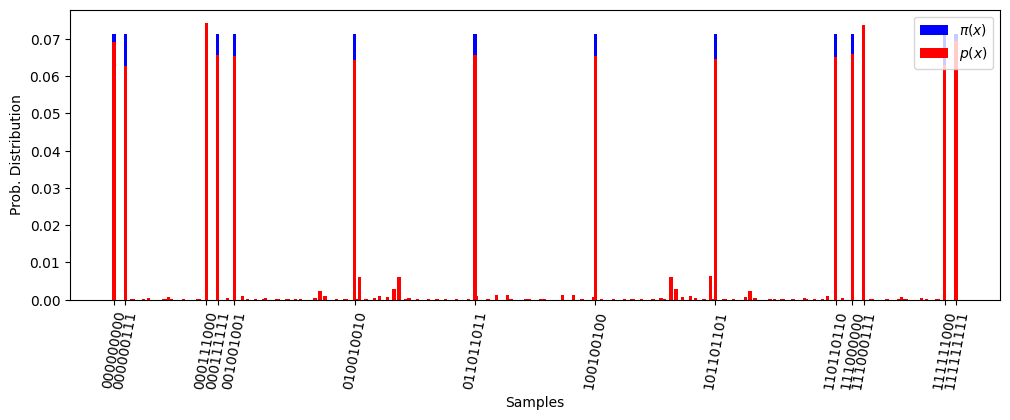

In [517]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$", color='blue')
plt.bar(np.arange(2**size), output_probs, width=2.0, label=r"$p(x)$",color='red')

plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

Accuracy of EFQ layer

In [518]:
acr4=0
for i in nums:
    acr4+=output_probs[i]
print(acr4)

0.9353050884856438


# Result comparision

Loss graph of all layers

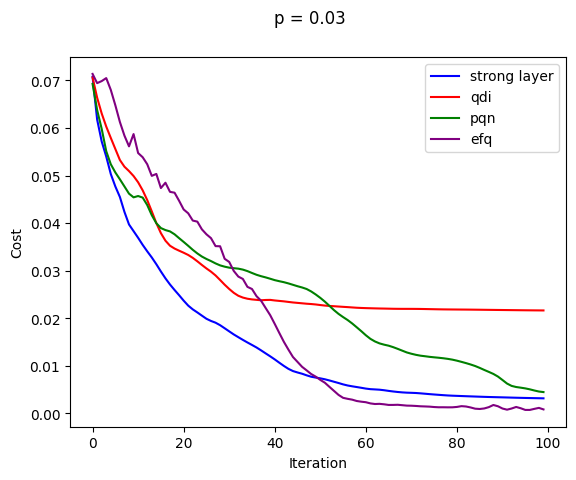

In [519]:
plt.plot(history, color='blue', label='strong layer')
plt.plot(history2, color='red', label='qdi')
plt.plot(history3, color='green', label='pqn')
plt.plot(history4, color='purple', label='efq')

plt.suptitle('p = 0.03')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend(loc="upper right")
plt.show()